In [1]:
import os
from pathlib import Path

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da
import gcsfs
import torch

import deepsensor.torch  # noqa: F401 (enables torch backend)
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device

# Local package utilities
from deepsensor_greatlakes.utils import (
    standardize_dates,
    generate_random_coordinates,
    apply_mask_to_prediction,
)
from deepsensor_greatlakes.preprocessor import (
    SeasonalCycleProcessor,
    list_saved_seasonal_cycles,
)
from deepsensor_greatlakes.model import save_model, load_convnp_model

set_gpu_default_device()
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


Using device: Tesla T4


In [10]:
# ===============================================================
# Project / GCS configuration
# ===============================================================
from pathlib import Path
import numpy as np
import torch

PROJECT_ID = "great-lakes-osd"
LOCATION   = "us-central1"

# Only store the bucket *name* here
BUCKET_NAME = "great-lakes-osd"

# Derive the gs:// form where needed
BUCKET = f"gs://{BUCKET_NAME}"

# Core datasets in GCS
BATHYMETRY_PATH        = f"{BUCKET}/context/gl_bathy_depth_3arcsec.nc"
LAKEMASK_PATH          = f"{BUCKET}/context/lakemask.nc"
ICE_CONCENTRATION_PATH = f"{BUCKET}/ice/ice_concentration_glsea3_838x1181_1995-2022.zarr"
GLSEA_PATH             = f"{BUCKET}/GLSEA_combined.zarr"

# ===============================================================
# Local folders for configs / models
# ===============================================================

# DataProcessor normalisation config
DATAPROCESSOR_DIR = Path("./deepsensor_config")
DATAPROCESSOR_DIR.mkdir(parents=True, exist_ok=True)

# Where to save the trained ConvNP model (best checkpoint)
MODEL_DIR_LOCAL = Path("./models/convnp_sst")
MODEL_DIR_LOCAL.mkdir(parents=True, exist_ok=True)

# (Optional) String for a GCS model folder if you later want to sync/upload
MODEL_DIR_GCS = f"{BUCKET}/models/convnp_sst"

# ===============================================================
# Time ranges (can tweak for quick tests vs full runs)
# ===============================================================

# For a smaller test run:
DATA_RANGE          = ("2009-01-01", "2010-12-31")
TRAIN_RANGE         = ("2009-01-01", "2009-12-31")
VAL_RANGE           = ("2010-01-01", "2010-12-31")
DATE_SUBSAMPLE_FACTOR = 30  # use larger for speed, smaller for more data

# =====================================================================
# CONFIG: Should we LOAD an existing DataProcessor, or BUILD a new one?
# =====================================================================
USE_EXISTING_DATAPROCESSOR = True   # Set to False to rebuild from scratch

# ===============================================================
# Training / model hyperparameters
# ===============================================================

N_RANDOM_POINTS  = 100      # number of random lake points per task (N buoys)
N_EPOCHS         = 50
LEARNING_RATE    = 5e-5
BATCH_SIZE       = 1        # start very small to avoid OOM, we can increase later
SEED             = 42
INTERNAL_DENSITY = 200     # start with 200–300; increase later

# Name of the GLSEA variable to predict 
TARGET_VAR_NAME = "sst"    # change to "sst_anom" etc. if needed

# Set seeds for reproducibility-ish behaviour
np.random.seed(SEED)
torch.manual_seed(SEED)

print("Config OK.")


Config OK.


In [3]:
# ===============================================================
# Load temporal datasets (ice concentration, GLSEA)
# ===============================================================

print("Opening Zarr datasets from GCS...")
ice_concentration_raw = xr.open_zarr(ICE_CONCENTRATION_PATH)
glsea_raw = xr.open_zarr(GLSEA_PATH)

# Replace sentinel land value -1 with NaN in ice concentration
ice_concentration_raw = ice_concentration_raw.where(ice_concentration_raw != -1, float("nan"))

# Drop the useless CRS variable if present
if "crs" in glsea_raw:
    glsea_raw = glsea_raw.drop_vars("crs")

# Convert times to date-only
ice_concentration_raw = standardize_dates(ice_concentration_raw)
glsea_raw = standardize_dates(glsea_raw)

# Restrict to chosen data range
t0, t1 = DATA_RANGE
ice_concentration_raw = ice_concentration_raw.sel(time=slice(t0, t1))
glsea_raw = glsea_raw.sel(time=slice(t0, t1))

print("ice_concentration:", ice_concentration_raw)
print("glsea:", glsea_raw)


Opening Zarr datasets from GCS...
ice_concentration: <xarray.Dataset> Size: 3GB
Dimensions:            (time: 730, lat: 838, lon: 1181)
Coordinates:
  * lat                (lat) float64 7kB 38.87 38.89 38.9 ... 50.58 50.59 50.61
  * lon                (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.9 -75.88
  * time               (time) datetime64[s] 6kB 2009-01-01 ... 2010-12-31
Data variables:
    ice_concentration  (time, lat, lon) float32 3GB dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
Attributes: (12/24)
    coverage_area:            Great Lakes
    data_source:              NOAA
    description:              Great Lakes ice concentrations
    disclaimer:               Data collected and processed by NOAA and dissem...
    dissemination:            USNIC Website, CIS Website
    grid_resolution:          1.800 km
    ...                       ...
    source:                   NAIS daily Great Lakes ice analysis
    source_url:               https://noaadata.apps.nsidc.org

In [4]:
# ===============================================================
# Load static datasets (bathymetry + lake mask) from GCS via gcsfs
# ===============================================================

print("Opening bathymetry + lake mask from GCS using gcsfs...")

fs = gcsfs.GCSFileSystem()

# gcsfs paths must be "bucket/path", not "gs://bucket/path"
bathy_path_gcsfs = f"{BUCKET_NAME}/context/gl_bathy_depth_3arcsec.nc"
mask_path_gcsfs  = f"{BUCKET_NAME}/context/lakemask.nc"

# IMPORTANT: Do NOT close these file objects — xarray needs them
bathy_fobj = fs.open(bathy_path_gcsfs, "rb")
mask_fobj  = fs.open(mask_path_gcsfs,  "rb")

bathymetry_raw = xr.open_dataset(bathy_fobj)
lakemask_raw   = xr.open_dataset(mask_fobj)

# ===============================================================
# Clean up bathymetry + lake mask datasets
# ===============================================================

# --- Clean bathymetry_raw ---
# Drop the useless CRS variable if present
if "crs" in bathymetry_raw:
    bathymetry_raw = bathymetry_raw.drop_vars("crs")

# Rename Band1 → depth (this will become much nicer downstream)
if "Band1" in bathymetry_raw:
    bathymetry_raw = bathymetry_raw.rename({"Band1": "depth"})

print("bathymetry_raw:", bathymetry_raw)
print("lakemask_raw:", lakemask_raw)


Opening bathymetry + lake mask from GCS using gcsfs...
bathymetry_raw: <xarray.Dataset> Size: 791MB
Dimensions:  (lat: 10201, lon: 19381)
Coordinates:
  * lat      (lat) float64 82kB 41.0 41.0 41.0 41.0 41.0 ... 49.5 49.5 49.5 49.5
  * lon      (lon) float64 155kB -92.2 -92.2 -92.2 ... -76.05 -76.05 -76.05
Data variables:
    depth    (lat, lon) float32 791MB ...
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 3.3.2, released 2021/09/01
    history:             Fri Nov 14 14:20:16 2025: GDAL CreateCopy( great_lak...
lakemask_raw: <xarray.Dataset> Size: 4MB
Dimensions:  (lon: 1181, lat: 838)
Coordinates:
  * lon      (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
  * lat      (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
Data variables:
    mask     (lat, lon) float32 4MB ...


In [5]:
# ===============================================================
# Construct circular day-of-year features
# ===============================================================

from deepsensor.data import construct_circ_time_ds

# Build a date coordinate covering the full GLSEA dataset
dates = pd.date_range(
    glsea_raw.time.values.min(),
    glsea_raw.time.values.max(),
    freq="D"
)

# Construct circular time dataset (cosine + sine of day-of-year)
# This dataset has its own time index matching "dates"
doy_ds = construct_circ_time_ds(dates, freq="D")

# Standardize times so they match the YYYY-MM-DD format everywhere else
cos_D = standardize_dates(doy_ds["cos_D"])
sin_D = standardize_dates(doy_ds["sin_D"])

print("Circular time features constructed:")
print("cos_D:", cos_D)
print("sin_D:", sin_D)


Circular time features constructed:
cos_D: <xarray.DataArray 'cos_D' (time: 730)> Size: 6kB
array([0.999852, 0.999408, 0.998669, ..., 0.999251, 0.999769, 0.999991],
      shape=(730,))
Coordinates:
  * time     (time) datetime64[s] 6kB 2009-01-01 2009-01-02 ... 2010-12-31
sin_D: <xarray.DataArray 'sin_D' (time: 730)> Size: 6kB
array([ 0.017202,  0.034398,  0.051584, ..., -0.038696, -0.021501, -0.004301],
      shape=(730,))
Coordinates:
  * time     (time) datetime64[s] 6kB 2009-01-01 2009-01-02 ... 2010-12-31


In [6]:
# ===============================================================
# DataProcessor Setup: Register all variables with correct scaling
# ===============================================================
#
# DeepSensor's DataProcessor learns normalization the FIRST time it
# sees each dataset. We therefore either:
#   - LOAD an existing, saved DataProcessor (preferred), or
#   - BUILD a new one and save it for future runs.
#
# Scaling strategy:
#   - SST (glsea) ....................... mean_std   (Gaussian-ish field)
#   - Ice Concentration ................. min_max    (bounded 0–1)
#   - Bathymetry ........................ min_max    (static absolute field)
#   - Lake Mask ......................... min_max    (binary 0/1, preserved)
#
# After registration, we process the full datasets with consistent scaling.
# ===============================================================

print("=== DataProcessor setup ===")

# 0. Attempt to LOAD existing DataProcessor, or BUILD a new one
if USE_EXISTING_DATAPROCESSOR and Path(DATAPROCESSOR_DIR).exists():
    print(f"Loading existing DataProcessor from: {DATAPROCESSOR_DIR}")
    data_processor = DataProcessor(DATAPROCESSOR_DIR)
    USING_LOADED_PROCESSOR = True

else:
    print("Building a NEW DataProcessor...")
    data_processor = DataProcessor(x1_name="lat", x2_name="lon")
    USING_LOADED_PROCESSOR = False

    # 1. Register SST (glsea) with MEAN-STD scaling
    print("  Registering SST (glsea) with mean_std scaling...")
    _ = data_processor(glsea_raw, method="mean_std")

    # 2. Register Ice Concentration with MIN-MAX scaling
    print("  Registering Ice Concentration with min_max scaling...")
    _ = data_processor(ice_concentration_raw, method="min_max")

    # 3. Register Bathymetry with MIN-MAX scaling
    print("  Registering bathymetry with min_max scaling...")
    _ = data_processor(bathymetry_raw, method="min_max")

    # 4. Register Lake Mask with MIN-MAX scaling
    print("  Registering lake mask with min_max scaling...")
    _ = data_processor(lakemask_raw, method="min_max")

    print("\nRegistration complete.")
    print("Registered variables:")
    for name, cfg in data_processor.config.items():
        print(f"  - {name}: {cfg}")

    # Save the learned scaling once
    data_processor.save(DATAPROCESSOR_DIR)
    print(f"\nSaved new DataProcessor to: {DATAPROCESSOR_DIR}")

if USING_LOADED_PROCESSOR:
    print("Using previously-saved normalization parameters.")

# ---------------------------------------------------------------
# Process all datasets with learned scaling
# ---------------------------------------------------------------
print("\nApplying DataProcessor scaling to all datasets...")

glsea             = data_processor(glsea_raw)
ice_concentration = data_processor(ice_concentration_raw)
bathymetry        = data_processor(bathymetry_raw)
lakemask          = data_processor(lakemask_raw)

print("\nDataProcessor processing complete.")
print(f"  glsea processed vars:             {list(glsea.data_vars)}")
print(f"  ice_concentration processed vars: {list(ice_concentration.data_vars)}")
print(f"  bathymetry processed vars:        {list(bathymetry.data_vars)}")
print(f"  lakemask processed vars:          {list(lakemask.data_vars)}")


=== DataProcessor setup ===
Loading existing DataProcessor from: deepsensor_config
Using previously-saved normalization parameters.

Applying DataProcessor scaling to all datasets...

DataProcessor processing complete.
  glsea processed vars:             ['sst']
  ice_concentration processed vars: ['ice_concentration']
  bathymetry processed vars:        ['depth']
  lakemask processed vars:          ['mask']


aux_ds: <xarray.Dataset> Size: 4MB
Dimensions:  (x1: 838, x2: 1181, time: 730)
Coordinates:
  * x1       (x1) float64 7kB 0.0 0.0008475 0.001695 ... 0.7076 0.7085 0.7093
  * x2       (x2) float64 9kB 0.0 0.0008475 0.001695 ... 0.9983 0.9992 1.0
  * time     (time) datetime64[s] 6kB 2009-01-01 2009-01-02 ... 2010-12-31
Data variables:
    mask     (x1, x2) float32 4MB -0.4052 -0.4052 -0.4052 ... -0.4052 -0.4052
    cos_D    (time) float64 6kB 0.9999 0.9994 0.9987 ... 0.9993 0.9998 1.0
    sin_D    (time) float64 6kB 0.0172 0.0344 0.05158 ... -0.0215 -0.004301

TaskLoader initialised:
TaskLoader(4 context sets, 1 target sets)
Context variable IDs: (('sst',), ('ice_concentration',), ('depth',), ('mask', 'cos_D', 'sin_D'))
Target variable IDs: (('sst',),)

Number of training dates:   13
Number of validation dates: 13


Generating tasks: 100%|██████████| 13/13 [00:35<00:00,  2.72s/it]



Generated 13 training tasks and 13 validation tasks.


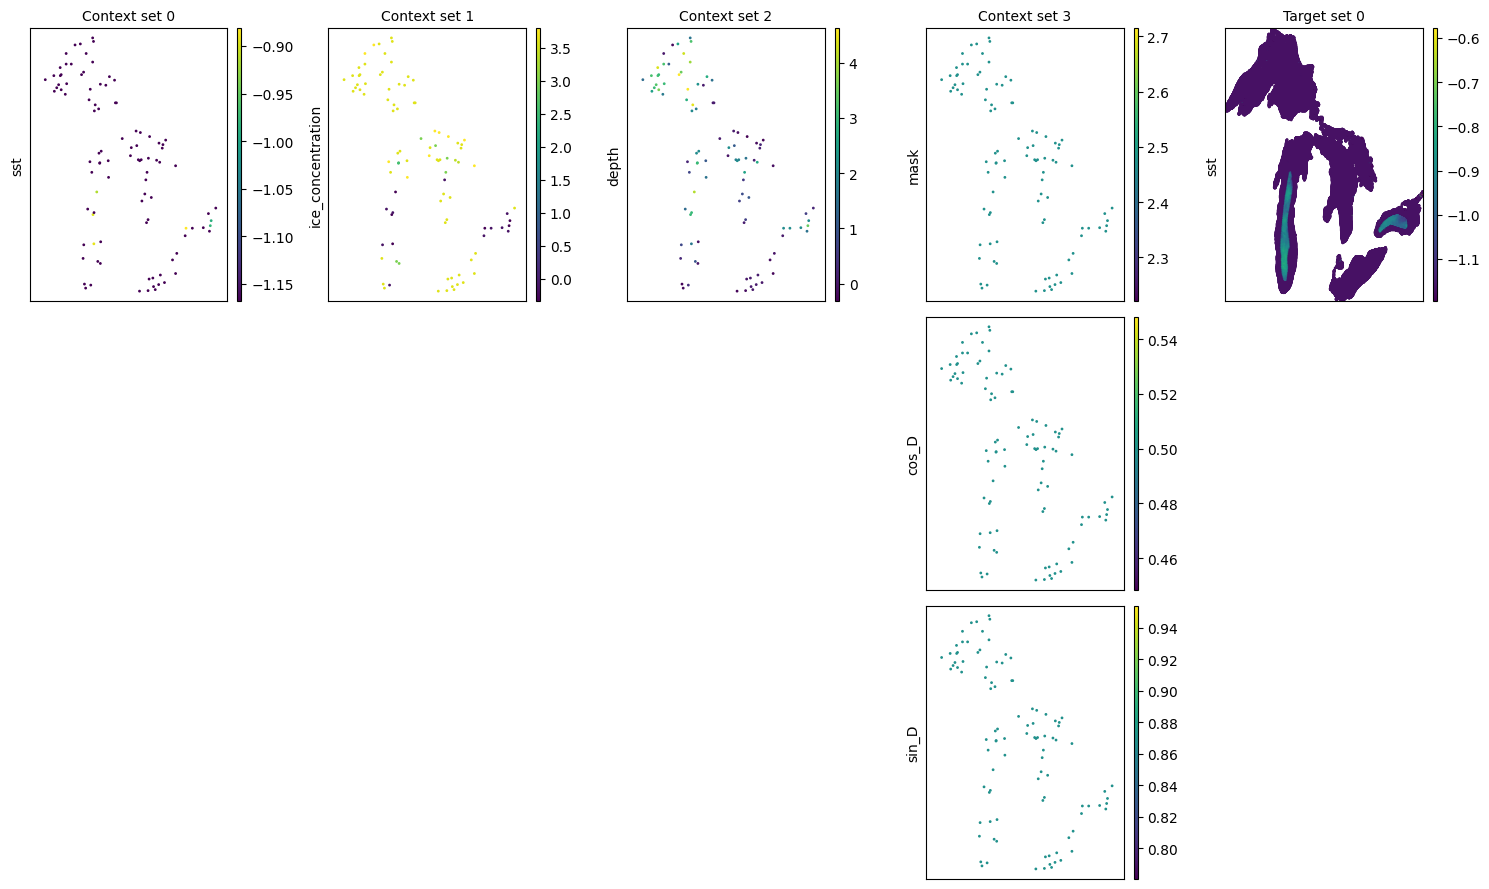

In [7]:
# ===============================================================
# TaskLoader setup and task generation
# ===============================================================
#
# We:
#   1. Build an auxiliary context dataset (static + time features)
#   2. Instantiate a TaskLoader with:
#        - context = [glsea, ice_concentration, aux_ds]
#        - target  = glsea (SST field)
#   3. Define a gen_tasks(...) helper to:
#        - sample N random lake points per date
#        - build tasks
#        - remove NaNs from targets
#   4. Generate train/val tasks
# ===============================================================

# 1. Auxiliary context dataset
#    Note: bathymetry var is now "depth", mask var is "mask".
aux_ds = xr.Dataset({
    "mask":  lakemask["mask"],      # processed lake mask (0/1)
    "cos_D": cos_D,                 # circular time features (already sin/cos)
    "sin_D": sin_D,
})

print("aux_ds:", aux_ds)

# 2. TaskLoader: contexts and target
task_loader = TaskLoader(
    context=[glsea, ice_concentration, bathymetry, aux_ds],
    target=glsea,
)

print("\nTaskLoader initialised:")
print(task_loader)


# 3. Task generation helper
def gen_tasks(dates, N=100, progress=True, lakemask_raw=None, data_processor=None):
    """
    Generate a list of DeepSensor tasks for given dates.

    Parameters
    ----------
    dates : iterable of np.datetime64 / pandas.Timestamp
        Dates at which to sample tasks.
    N : int
        Number of random lake points (context locations) per task.
    progress : bool
        If True, show tqdm progress bar.
    lakemask_raw : xr.Dataset
        Raw lake mask dataset used by `generate_random_coordinates`.
    data_processor : deepsensor.data.DataProcessor
        DataProcessor instance used to normalise coordinates.

    Returns
    -------
    tasks : list
        List of DeepSensor Task objects.
    """
    if lakemask_raw is None or data_processor is None:
        raise ValueError("You must pass both `lakemask_raw` and `data_processor`.")

    tasks = []
    for date in tqdm(dates, disable=not progress, desc="Generating tasks"):
        # Generate a fresh set of random lake points for each date
        random_points = generate_random_coordinates(lakemask_raw, N, data_processor)

        # Sample the task:
        #   - context_sampling: use our N random coordinates
        #   - target_sampling:  "all" → full SST field on that date
        task = task_loader(date, context_sampling=random_points, target_sampling="all")

        # Remove NaNs from the target (e.g., land, missing data)
        task = task.remove_target_nans()

        tasks.append(task)

    return tasks


# 4. Build train/validation date lists
#    (Assumes TRAIN_RANGE, VAL_RANGE, DATE_SUBSAMPLE_FACTOR are already defined,
#     e.g.: TRAIN_RANGE = ("2009-01-01","2009-12-31"), etc.)

train_dates = pd.date_range(TRAIN_RANGE[0], TRAIN_RANGE[1])[::DATE_SUBSAMPLE_FACTOR]
val_dates   = pd.date_range(VAL_RANGE[0],   VAL_RANGE[1])[::DATE_SUBSAMPLE_FACTOR]

# Normalize to datetime64[D]
train_dates = pd.to_datetime(train_dates).normalize()
val_dates   = pd.to_datetime(val_dates).normalize()

print(f"\nNumber of training dates:   {len(train_dates)}")
print(f"Number of validation dates: {len(val_dates)}")


# 5. Generate training and validation tasks
train_tasks = gen_tasks(
    train_dates,
    N=100,  # number of random lake points per task
    lakemask_raw=lakemask_raw,
    data_processor=data_processor,
)

val_tasks = gen_tasks(
    val_dates,
    N=100,
    lakemask_raw=lakemask_raw,
    data_processor=data_processor,
)

print(f"\nGenerated {len(train_tasks)} training tasks and {len(val_tasks)} validation tasks.")


# 6. Quick sanity check plot of one task
fig = deepsensor.plot.task(train_tasks[2], task_loader)
plt.show()


Initialising ConvNP model and Trainer...
dim_yc inferred from TaskLoader: (1, 1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
encoder_scales inferred from TaskLoader: [np.float32(0.0004237288), np.float32(0.0004237288), np.float32(2.5194027e-05), np.float32(0.0004237288)]
decoder_scale inferred from TaskLoader: 0.005
Model and Trainer ready.
Training for 50 epochs with lr=5e-05, batch_size=1

=== Starting training loop ===


Training epochs:   2%|▏         | 1/50 [00:07<06:00,  7.35s/it]

Epoch 001 | loss = 1.3653 | val RMSE = 7.5968
  ↳ New best model saved to models/convnp_sst (RMSE = 7.5968)


Training epochs:   4%|▍         | 2/50 [00:13<05:31,  6.91s/it]

Epoch 002 | loss = 1.3580 | val RMSE = 7.5615
  ↳ New best model saved to models/convnp_sst (RMSE = 7.5615)


Training epochs:   6%|▌         | 3/50 [00:20<05:15,  6.70s/it]

Epoch 003 | loss = 1.3546 | val RMSE = 7.5990


Training epochs:   8%|▊         | 4/50 [00:26<05:02,  6.58s/it]

Epoch 004 | loss = 1.3499 | val RMSE = 7.5481
  ↳ New best model saved to models/convnp_sst (RMSE = 7.5481)


Training epochs:  10%|█         | 5/50 [00:33<04:50,  6.45s/it]

Epoch 005 | loss = 1.3484 | val RMSE = 7.5442
  ↳ New best model saved to models/convnp_sst (RMSE = 7.5442)


Training epochs:  12%|█▏        | 6/50 [00:39<04:42,  6.42s/it]

Epoch 006 | loss = 1.3511 | val RMSE = 7.5153
  ↳ New best model saved to models/convnp_sst (RMSE = 7.5153)


Training epochs:  14%|█▍        | 7/50 [00:45<04:35,  6.41s/it]

Epoch 007 | loss = 1.3426 | val RMSE = 7.5039
  ↳ New best model saved to models/convnp_sst (RMSE = 7.5039)


Training epochs:  16%|█▌        | 8/50 [00:52<04:28,  6.39s/it]

Epoch 008 | loss = 1.3413 | val RMSE = 7.4520
  ↳ New best model saved to models/convnp_sst (RMSE = 7.4520)


Training epochs:  18%|█▊        | 9/50 [00:58<04:20,  6.36s/it]

Epoch 009 | loss = 1.3365 | val RMSE = 7.4312
  ↳ New best model saved to models/convnp_sst (RMSE = 7.4312)


Training epochs:  20%|██        | 10/50 [01:04<04:12,  6.30s/it]

Epoch 010 | loss = 1.3390 | val RMSE = 7.3170
  ↳ New best model saved to models/convnp_sst (RMSE = 7.3170)


Training epochs:  22%|██▏       | 11/50 [01:10<04:06,  6.33s/it]

Epoch 011 | loss = 1.3160 | val RMSE = 7.3352


Training epochs:  24%|██▍       | 12/50 [01:17<04:01,  6.35s/it]

Epoch 012 | loss = 1.3008 | val RMSE = 7.1717
  ↳ New best model saved to models/convnp_sst (RMSE = 7.1717)


Training epochs:  26%|██▌       | 13/50 [01:23<03:53,  6.31s/it]

Epoch 013 | loss = 1.2812 | val RMSE = 7.0869
  ↳ New best model saved to models/convnp_sst (RMSE = 7.0869)


Training epochs:  28%|██▊       | 14/50 [01:29<03:47,  6.31s/it]

Epoch 014 | loss = 1.2875 | val RMSE = 6.9642
  ↳ New best model saved to models/convnp_sst (RMSE = 6.9642)


Training epochs:  30%|███       | 15/50 [01:36<03:43,  6.38s/it]

Epoch 015 | loss = 1.2452 | val RMSE = 6.8374
  ↳ New best model saved to models/convnp_sst (RMSE = 6.8374)


Training epochs:  32%|███▏      | 16/50 [01:42<03:36,  6.37s/it]

Epoch 016 | loss = 1.1872 | val RMSE = 6.8476


Training epochs:  34%|███▍      | 17/50 [01:49<03:28,  6.33s/it]

Epoch 017 | loss = 1.1392 | val RMSE = 6.0101
  ↳ New best model saved to models/convnp_sst (RMSE = 6.0101)


Training epochs:  36%|███▌      | 18/50 [01:55<03:23,  6.35s/it]

Epoch 018 | loss = 1.1436 | val RMSE = 5.6601
  ↳ New best model saved to models/convnp_sst (RMSE = 5.6601)


Training epochs:  38%|███▊      | 19/50 [02:01<03:16,  6.34s/it]

Epoch 019 | loss = 0.9651 | val RMSE = 5.1411
  ↳ New best model saved to models/convnp_sst (RMSE = 5.1411)


Training epochs:  40%|████      | 20/50 [02:08<03:10,  6.36s/it]

Epoch 020 | loss = 0.9371 | val RMSE = 4.9745
  ↳ New best model saved to models/convnp_sst (RMSE = 4.9745)


Training epochs:  42%|████▏     | 21/50 [02:14<03:03,  6.34s/it]

Epoch 021 | loss = 0.7941 | val RMSE = 4.6033
  ↳ New best model saved to models/convnp_sst (RMSE = 4.6033)


Training epochs:  44%|████▍     | 22/50 [02:20<02:56,  6.31s/it]

Epoch 022 | loss = 0.8800 | val RMSE = 5.0873


Training epochs:  46%|████▌     | 23/50 [02:27<02:51,  6.35s/it]

Epoch 023 | loss = 0.8472 | val RMSE = 4.9562


Training epochs:  48%|████▊     | 24/50 [02:33<02:45,  6.37s/it]

Epoch 024 | loss = 0.7469 | val RMSE = 4.2106
  ↳ New best model saved to models/convnp_sst (RMSE = 4.2106)


Training epochs:  50%|█████     | 25/50 [02:40<02:40,  6.41s/it]

Epoch 025 | loss = 0.5769 | val RMSE = 3.9563
  ↳ New best model saved to models/convnp_sst (RMSE = 3.9563)


Training epochs:  52%|█████▏    | 26/50 [02:46<02:34,  6.43s/it]

Epoch 026 | loss = 0.6089 | val RMSE = 3.9132
  ↳ New best model saved to models/convnp_sst (RMSE = 3.9132)


Training epochs:  54%|█████▍    | 27/50 [02:52<02:26,  6.36s/it]

Epoch 027 | loss = 0.5817 | val RMSE = 3.7709
  ↳ New best model saved to models/convnp_sst (RMSE = 3.7709)


Training epochs:  56%|█████▌    | 28/50 [02:59<02:19,  6.34s/it]

Epoch 028 | loss = 0.4852 | val RMSE = 3.8083


Training epochs:  58%|█████▊    | 29/50 [03:05<02:13,  6.37s/it]

Epoch 029 | loss = 0.4893 | val RMSE = 4.1531


Training epochs:  60%|██████    | 30/50 [03:11<02:06,  6.32s/it]

Epoch 030 | loss = 0.9222 | val RMSE = 4.1569


Training epochs:  62%|██████▏   | 31/50 [03:17<01:59,  6.29s/it]

Epoch 031 | loss = 0.7316 | val RMSE = 3.9337


Training epochs:  64%|██████▍   | 32/50 [03:24<01:52,  6.26s/it]

Epoch 032 | loss = 0.6693 | val RMSE = 3.8066


Training epochs:  66%|██████▌   | 33/50 [03:30<01:46,  6.26s/it]

Epoch 033 | loss = 0.5583 | val RMSE = 3.5163
  ↳ New best model saved to models/convnp_sst (RMSE = 3.5163)


Training epochs:  68%|██████▊   | 34/50 [03:36<01:39,  6.25s/it]

Epoch 034 | loss = 0.4122 | val RMSE = 3.4491
  ↳ New best model saved to models/convnp_sst (RMSE = 3.4491)


Training epochs:  70%|███████   | 35/50 [03:42<01:33,  6.26s/it]

Epoch 035 | loss = 0.5889 | val RMSE = 3.8907


Training epochs:  72%|███████▏  | 36/50 [03:49<01:27,  6.26s/it]

Epoch 036 | loss = 0.5399 | val RMSE = 3.8535


Training epochs:  74%|███████▍  | 37/50 [03:55<01:21,  6.30s/it]

Epoch 037 | loss = 0.6098 | val RMSE = 3.6852


Training epochs:  76%|███████▌  | 38/50 [04:01<01:15,  6.25s/it]

Epoch 038 | loss = 0.4594 | val RMSE = 3.5489


Training epochs:  78%|███████▊  | 39/50 [04:07<01:08,  6.26s/it]

Epoch 039 | loss = 0.4103 | val RMSE = 3.3914
  ↳ New best model saved to models/convnp_sst (RMSE = 3.3914)


Training epochs:  80%|████████  | 40/50 [04:14<01:02,  6.26s/it]

Epoch 040 | loss = 0.3090 | val RMSE = 3.3633
  ↳ New best model saved to models/convnp_sst (RMSE = 3.3633)


Training epochs:  82%|████████▏ | 41/50 [04:20<00:56,  6.26s/it]

Epoch 041 | loss = 0.3029 | val RMSE = 3.3480
  ↳ New best model saved to models/convnp_sst (RMSE = 3.3480)


Training epochs:  84%|████████▍ | 42/50 [04:26<00:50,  6.26s/it]

Epoch 042 | loss = 0.3714 | val RMSE = 3.2596
  ↳ New best model saved to models/convnp_sst (RMSE = 3.2596)


Training epochs:  86%|████████▌ | 43/50 [04:32<00:43,  6.24s/it]

Epoch 043 | loss = 0.4170 | val RMSE = 3.4479


Training epochs:  88%|████████▊ | 44/50 [04:38<00:37,  6.20s/it]

Epoch 044 | loss = 0.3203 | val RMSE = 3.3800


Training epochs:  90%|█████████ | 45/50 [04:45<00:31,  6.22s/it]

Epoch 045 | loss = 0.2603 | val RMSE = 3.0846
  ↳ New best model saved to models/convnp_sst (RMSE = 3.0846)


Training epochs:  92%|█████████▏| 46/50 [04:51<00:25,  6.26s/it]

Epoch 046 | loss = 0.1790 | val RMSE = 3.5569


Training epochs:  94%|█████████▍| 47/50 [04:57<00:18,  6.27s/it]

Epoch 047 | loss = 0.6687 | val RMSE = 4.2044


Training epochs:  96%|█████████▌| 48/50 [05:04<00:12,  6.25s/it]

Epoch 048 | loss = 0.6924 | val RMSE = 3.9864


Training epochs:  98%|█████████▊| 49/50 [05:10<00:06,  6.27s/it]

Epoch 049 | loss = 0.5233 | val RMSE = 3.4321


Training epochs: 100%|██████████| 50/50 [05:16<00:00,  6.34s/it]

Epoch 050 | loss = 0.3714 | val RMSE = 3.4583

Training complete.
Best validation RMSE: 3.0846


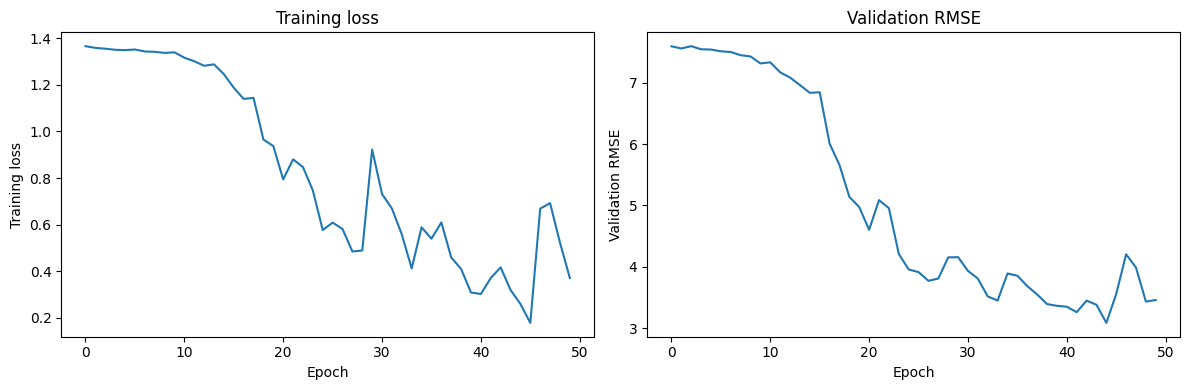

In [11]:
# ---------------------------------------------------------------
# 1. Device + model + trainer
# ---------------------------------------------------------------

print("Initialising ConvNP model and Trainer...")
model = ConvNP(
    data_processor, 
    task_loader,
    internal_density=INTERNAL_DENSITY,
)

# Trainer only takes (model, lr)
trainer = Trainer(
    model,
    lr=LEARNING_RATE,
)

# For un-normalising SST later
target_var_ID = task_loader.target_var_IDs[0][0]  # first target, 1D

print("Model and Trainer ready.")
print(f"Training for {N_EPOCHS} epochs with lr={LEARNING_RATE:g}, batch_size={BATCH_SIZE}")

# ---------------------------------------------------------------
# 2. Helper: validation RMSE in physical SST units
# ---------------------------------------------------------------

def compute_val_rmse(model, val_tasks, task_loader, data_processor, target_var_ID):
    """
    Compute RMSE over all validation tasks in un-normalised SST units.
    """
    errors = []

    for task in val_tasks:
        with torch.no_grad():
            # Mean prediction in normalised space
            mean_norm = model.mean(task)

            # Map prediction and truth back to physical SST
            mean = data_processor.map_array(
                mean_norm,
                target_var_ID,
                unnorm=True,
            )
            true = data_processor.map_array(
                task["Y_t"][0],
                target_var_ID,
                unnorm=True,
            )

        diff = mean - true
        errors.append(diff.ravel() ** 2)

        torch.cuda.empty_cache()

    errors = np.concatenate(errors)
    rmse = float(np.sqrt(np.mean(errors)))
    return rmse

# ---------------------------------------------------------------
# 3. Training loop (now using Trainer.__call__ with batch_size)
# ---------------------------------------------------------------

losses        = []
val_rmses     = []
best_val_rmse = np.inf

print("\n=== Starting training loop ===")

for epoch in tqdm(range(1, N_EPOCHS + 1), desc="Training epochs"):
    # 🔹 IMPORTANT: pass batch_size here to avoid OOM
    batch_losses = trainer(
        train_tasks,
        batch_size=BATCH_SIZE,      # this is the DeepSensor-supported batching
        progress_bar=False,
        tqdm_notebook=False,
    )
    epoch_loss = float(np.mean(batch_losses))
    losses.append(epoch_loss)

    # Validation RMSE in physical SST units
    val_rmse = compute_val_rmse(
        model,
        val_tasks,
        task_loader,
        data_processor,
        target_var_ID,
    )
    val_rmses.append(val_rmse)

    print(f"Epoch {epoch:03d} | loss = {epoch_loss:.4f} | val RMSE = {val_rmse:.4f}")

    # Save best model so far
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        save_model(model, MODEL_DIR_LOCAL)
        print(f"  ↳ New best model saved to {MODEL_DIR_LOCAL} (RMSE = {best_val_rmse:.4f})")

    torch.cuda.empty_cache()

print("\nTraining complete.")
print(f"Best validation RMSE: {best_val_rmse:.4f}")

# ---------------------------------------------------------------
# 4. Plot training diagnostics
# ---------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(losses)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Training loss")
axes[0].set_title("Training loss")

axes[1].plot(val_rmses)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation RMSE")
axes[1].set_title("Validation RMSE")

plt.tight_layout()
plt.show()


In [12]:
# ===============================================================
# Single prediction on one validation date
# ===============================================================

from deepsensor_greatlakes.model import load_convnp_model

# 1. Reload best model from disk (to confirm save/load works)
print(f"Loading best model from {MODEL_DIR_LOCAL} ...")
best_model = load_convnp_model(MODEL_DIR_LOCAL, data_processor, task_loader)
print("Model loaded.")

# 2. Choose a prediction date (first validation date, for example)
PRED_DATE = val_dates[0]
print(f"Making prediction for date: {PRED_DATE}")

# 3. Sample context points for this date
context_points = generate_random_coordinates(
    lakemask_raw,
    N_RANDOM_POINTS,
    data_processor,
)

# 4. Build a task for this date
test_task = task_loader(
    PRED_DATE,
    context_sampling=context_points,
    target_sampling="all",
)

# 5. Run prediction.
#    X_t argument defines where we want the output grid; using raw GLSEA grid here.
pred_ds = best_model.predict(test_task, X_t=glsea_raw)

print("Prediction dataset:")
print(pred_ds)


Loading best model from models/convnp_sst ...
Attempting to instantiate ConvNP model (randomly initialized initially):
Architectural config for construct_neural_process (passed as **kwargs): {'dim_x': 2, 'dim_yc': [1, 1, 1, 3], 'dim_yt': 1, 'dim_aux_t': 0, 'dim_lv': 0, 'conv_arch': 'unet', 'unet_channels': [64, 64, 64, 64], 'unet_resize_convs': True, 'unet_resize_conv_interp_method': 'bilinear', 'aux_t_mlp_layers': None, 'likelihood': 'het', 'unet_kernels': 5, 'internal_density': 200, 'encoder_scales': [0.0004237288, 0.0004237288, 2.5194027e-05, 0.0004237288], 'encoder_scales_learnable': False, 'decoder_scale': 0.005, 'decoder_scale_learnable': False, 'num_basis_functions': 64, 'epsilon': 0.01}
Model loaded.
Making prediction for date: 2010-01-01 00:00:00
Prediction dataset:
Prediction({'sst': ('mean', 'std')}), mode=on-grid


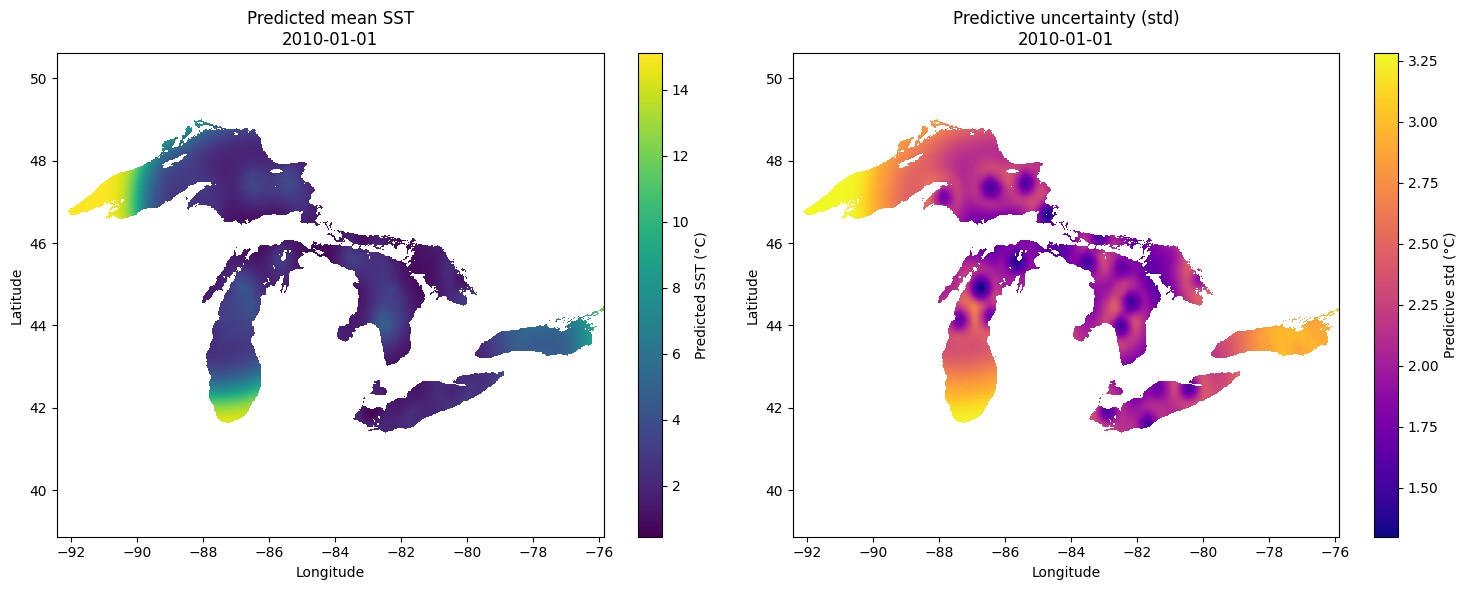

In [13]:
# ===============================================================
# Mask prediction to lake and plot mean + std
# ===============================================================

# Extract the SST field from the prediction dataset
sst_pred = pred_ds[TARGET_VAR_NAME]   # "sst"

# Apply lake mask (your helper handles matching coords)
sst_pred_masked = apply_mask_to_prediction(sst_pred, lakemask_raw)

plt.figure(figsize=(15, 6))

# Mean
plt.subplot(1, 2, 1)
sst_pred_masked["mean"].plot(
    cmap="viridis",
    cbar_kwargs={"label": "Predicted SST (°C)"},
)
plt.title(f"Predicted mean SST\n{np.array(PRED_DATE).astype('datetime64[D]')}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Std (uncertainty)
plt.subplot(1, 2, 2)
sst_pred_masked["std"].plot(
    cmap="plasma",
    cbar_kwargs={"label": "Predictive std (°C)"},
)
plt.title(f"Predictive uncertainty (std)\n{np.array(PRED_DATE).astype('datetime64[D]')}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()
